In [1]:
import sys
import os
from os.path import join, abspath, exists
root = abspath(join(os.getcwd(), '../..'))
if root not in sys.path:
    sys.path.append(root)

In [ ]:
%load_ext autoreload
%autoreload 2

from riskformer.data.datasets import create_riskformer_dataset
from riskformer.utils.config_utils import load_preprocessing_config, load_train_config
from riskformer.utils.logger_config import logger_setup

train_config = load_train_config(join(root, "configs/training/ec2_config.yaml"))
dataset_metadata = join(root, "resources/riskformer_slide_samples.json")
prep_config_path = join(root, "configs/preprocessing/ec2_config.yaml")
prep_config = load_preprocessing_config(prep_config_path)

if train_config:
    max_dim = train_config["prep"]["max_dim"]
    overlap = train_config["prep"]["overlap"]
else:
    max_dim = 32
    overlap = 0.0

logger_setup(
    "notebooks-datasets",
    log_dir=join(root, "logs"),
    debug=False)

dataset = create_riskformer_dataset(
    s3_bucket=prep_config["s3"]["data_bucket"],
    s3_prefix=join(prep_config["s3"]["output_dir"], prep_config["model"]["key"]),
    max_dim=max_dim,
    overlap=overlap,
    metadata_file=dataset_metadata,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1
/home/ec2-user/brca_riskformer/logs


[03/08/25 00:02:02] INFO     Logger already configured, skipping setup.                         ]8;id=29467;file:///home/ec2-user/brca_riskformer/riskformer/utils/logger_config.py\logger_config.py]8;;\:]8;id=541261;file:///home/ec2-user/brca_riskformer/riskformer/utils/logger_config.py#80\80]8;;\

                    INFO     Loading cached SSO token for mgb                                         ]8;id=30822;file:///opt/conda/envs/pytorch/lib/python3.11/site-packages/botocore/tokens.py\tokens.py]8;;\:]8;id=573600;file:///opt/conda/envs/pytorch/lib/python3.11/site-packages/botocore/tokens.py#305\305]8;;\

[03/08/25 00:02:03] INFO     {"event":"load_metadata","status":"success","timestamp":"2025-03- ]8;id=620573;file:///home/ec2-user/brca_riskformer/riskformer/utils/logger_config.py\logger_config.py]8;;\:]8;id=376326;file:///home/ec2-user/brca_riskformer/riskformer/utils/logger_config.py#178\178]8;;\
                             08T00:02:03.167844","total_slides":1099}                                              

                    INFO     {"event":"find_complete_slide_sets","status":"success","timestamp ]8;id=684853;file:///home/ec2-user/brca_riskformer/riskformer/utils/logger_config.py\logger_config.py]8;;\:]8;id=344957;file:///home/ec2-user/brca_riskformer/riskformer/utils/logger_config.py#178\178]8;;\
                             ":"2025-03-08T00:02:03.251635","total_files":208,"total_slides_in                     
                             _metadata":1099,"preprocessed_slides_found":52,"missing_slides":1                     
                             047}                                                                                  

                    INFO     {"event":"create_riskformer_dataset","status":"success","timestam ]8;id=605399;file:///home/ec2-user/brca_riskformer/riskformer/utils/logger_config.py\logger_config.py]8;;\:]8;id=505992;file:///home/ec2-user/brca_riskformer/riskformer/utils/logger_config.py#178\178]8;;\
                             p":"2025-03-08T00:02:03.259085","slide_count":50,"feature_dim":15                     
                             36,"cache_dir":"/tmp/riskformer_cache"}                                               

test_data:
Slide ID: TCGA-3C-AALJ
XL pathces: 74
XL patch size: torch.Size([32, 32, 1536])
	coords_paths: ['s3://tcga-riskformer-data-2025/preprocessed/uni/uni2-h/TCGA-3C-AALJ-01Z-00-DX1.777C0957-255A-42F0-9EEB-A3606BCF0C96_coords.h5', 's3://tcga-riskformer-data-2025/preprocessed/uni/uni2-h/TCGA-3C-AALJ-01Z-00-DX2.62DFE56B-B84C-40F9-9625-FCB55767B70D_coords.h5']
	features_paths: ['s3://tcga-riskformer-data-2025/preprocessed/uni/uni2-h/TCGA-3C-AALJ-01Z-00-DX1.777C0957-255A-42F0-9EEB-A3606BCF0C96_features.h5', 's3://tcga-riskformer-data-2025/preprocessed/uni/uni2-h/TCGA-3C-AALJ-01Z-00-DX2.62DFE56B-B84C-40F9-9625-FCB55767B70D_features.h5']
	odx_train: 0.9376
	odx85: 1
	mphr: 1
	dfm: 48.43987146
	necrosis: 0
	pleo: 3


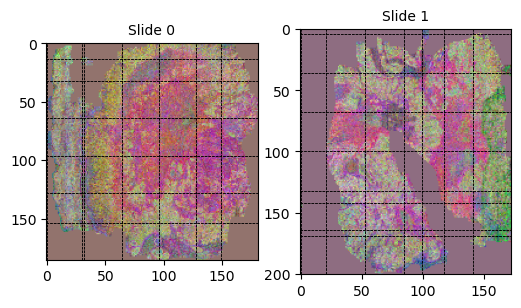

In [58]:
import matplotlib.pyplot as plt
from riskformer.utils.training_utils import rearrange_xl_patches, PatchInfo

xl_patches, xl_patch_info, id, labels = dataset[1]
reconstructed_features, (row_starts, col_starts) = rearrange_xl_patches(xl_patches, xl_patch_info.cpu().numpy())
xl_patch_info = PatchInfo.from_tensor_batch(xl_patch_info)

print("test_data:")
print(f"Slide ID: {id}")
print(f"XL pathces: {xl_patches.shape[0]}")
print(f"XL patch size: {xl_patches.shape[1:]}")
for k,v in labels.items():
    print(f"\t{k}: {v}")

n = len(reconstructed_features)
fig_size = 6
f, ax = plt.subplots(1, n, figsize=(fig_size, fig_size * n))
for i, feature in enumerate(reconstructed_features):
    slice = feature.cpu().numpy()
    slice = (slice - slice.min(axis=(0, 1))) / (slice.max(axis=(0, 1)) - slice.min(axis=(0, 1)))
    ax[i].imshow(slice[..., :3])
    # ax[i].axis('off')
    ax[i].set_title(f"Slide {i}", fontsize=10)

    for (feature_id, col_start) in col_starts:
        ax[feature_id].axvline(col_start, color='k', linestyle='--', linewidth=0.5)
    for (feature_id, row_start) in row_starts:
        ax[feature_id].axhline(row_start, color='k', linestyle='--', linewidth=0.5)
plt.show()

In [63]:
from riskformer.training.riskformer_vit import RiskFormer_ViT

input_embed_dim = 1536
output_embed_dim = 128
use_phi = True
phi_dim = None
depth = 12
global_depth = 0
downscale_depth = 1
downscale_multiplier = 1.0
downscale_stride_q = 2
downscale_stride_k = 2
attnpool_mode = "conv"
mlp_ratio = 2.0
num_heads = 4
num_classes = 5

use_class_token = False
use_attn_mask = False
encoding_method = "sinusoidal"
mask_num = 1
mask_preglobal = True

drop_path_rate = 0.4
drop_rate = 0.1
noise_aug = 0.1
global_k = -1

name=f"riskformer_vit_{max_dim}"
model = RiskFormer_ViT(
    input_embed_dim=input_embed_dim,
    output_embed_dim=output_embed_dim,
    use_phi=use_phi,
    drop_path_rate=drop_path_rate,
    drop_rate=drop_rate,
    num_classes=num_classes,
    max_dim=max_dim,
    depth=depth,
    global_depth=global_depth,
    encoding_method=encoding_method,
    mask_num=mask_num,
    mask_preglobal=mask_preglobal,
    num_heads=num_heads,
    use_attn_mask=use_attn_mask,
    mlp_ratio=mlp_ratio,
    use_class_token=use_class_token,
    global_k=global_k,
    phi_dim=phi_dim,
    downscale_depth=downscale_depth,
    downscale_multiplier=downscale_multiplier,
    downscale_stride_q=downscale_stride_q,
    downscale_stride_k=downscale_stride_k,
    noise_aug=noise_aug,
    attnpool_mode=attnpool_mode,
    name=name
)


In [64]:
forward_pass = model(xl_patches)
forward_pass.shape

torch.Size([74, 5])